# A Toy Example of Domain Adaptation using Distilling

Keywords:
1. Domain adaptation with **Distilling**
  $$\text{Gradients}\left[\text{XEnt}(q_i,p_i)\right] \approx \text{Gradients}\left[\text{MSE}(z_i/T,v_i/T)\right]$$
  - So we use mean square error on logits which are devided by temerature $T$


2. A good way to create a Dataset API pipeline [[ref](https://www.tensorflow.org/guide/data_performance?hl=zh_cn)]
  - if `map()` has random ops: `dataset.shuffle().batch().cache().map().prefetch()`
  - `map()` has NO random ops: `dataset.shuffle().batch().map().cache().prefetch()`


3. **Init model with a pre-trained model** (same model structure)


4. Freeze some variables during training

5. learn how to use `tf.keras.metrics.SparseCategoricalAccuracy`

---
Suppose we have a model already trained to classify '6' and '9' and the new domain is a upside down world.

<img src="cover2.png" width=40% height=40%>

How to adapt this model without using labeled data in new domain? So that we can classify the upside down '6' and '9'.

"[Large-Scale Domain Adaptation via Teacher-Student Learning](https://arxiv.org/abs/1708.05466)" provides a possible and simple way

The algorithm architecture is below:
<img src="TS-paper-fig1.png" width=40% height=40%>

We will show that using parallel data (unsupervised) and distilling, we can adapt model to classify the upside-down '6' and '9'

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout, BatchNormalization
from tensorflow.keras import Model
%matplotlib inline
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import pylab
import pickle, time

## A. Data loading

In [2]:
# fashionMnist
fmnist = tf.keras.datasets.fashion_mnist
(x_fmnist, y_fmnist), _ = fmnist.load_data()
x_fmnist = x_fmnist[...,tf.newaxis]/255.0 - 0.5
# Mnist, we only care about '6' and '9' (label 0 and 1)
mnist = tf.keras.datasets.mnist
(x_mnist_train, y_mnist_train), (x_mnist_test, y_mnist_test) = mnist.load_data()
x_mnist_train = x_mnist_train[...,tf.newaxis]/255.0 - 0.5
x_mnist_test = x_mnist_test[...,tf.newaxis]/255.0 - 0.5

# prepare unsupervised training data for domain adaptation
x_adpt = x_fmnist

# prepare mnist (only '6' and '9')
x_mnist_train, y_mnist_train = zip(*[(x,y) for x,y in zip(x_mnist_train, y_mnist_train) if (y==6 or y==9)])
x_mnist_test, y_mnist_test = zip(*[(x,y) for x,y in zip(x_mnist_test, y_mnist_test) if (y==6 or y==9)])
x_mnist_train, y_mnist_train = np.array(x_mnist_train, dtype=np.float32), np.array(y_mnist_train, dtype=np.int)
x_mnist_test, y_mnist_test = np.array(x_mnist_test, dtype=np.float32), np.array(y_mnist_test, dtype=np.int)
y_mnist_train[y_mnist_train==6], y_mnist_train[y_mnist_train==9] = 0, 1
y_mnist_test[y_mnist_test==6], y_mnist_test[y_mnist_test==9] = 0, 1

print("x_adpt.shape = ",x_adpt.shape,"; min = ",np.min(x_adpt),"; max = ",np.max(x_adpt))
print("x_mnist_train.shape = ",x_mnist_train.shape,"; min = ",np.min(x_mnist_train),"; max = ",np.max(x_mnist_train))
print("x_mnist_test.shape = ",x_mnist_test.shape,"; min = ",np.min(x_mnist_test),"; max = ",np.max(x_mnist_test))

x_adpt.shape =  (60000, 28, 28, 1) ; min =  -0.5 ; max =  0.5
x_mnist_train.shape =  (11867, 28, 28, 1) ; min =  -0.5 ; max =  0.5
x_mnist_test.shape =  (1967, 28, 28, 1) ; min =  -0.5 ; max =  0.5


In [3]:
_, h, w, c = x_mnist_train.shape

train_mnist_ds = tf.data.Dataset.from_tensor_slices((x_mnist_train, y_mnist_train)).shuffle(10000).batch(32).prefetch(tf.data.experimental.AUTOTUNE)
test_mnist_ds = tf.data.Dataset.from_tensor_slices((x_mnist_test, y_mnist_test)).batch(32).prefetch(tf.data.experimental.AUTOTUNE)

## B. Base model structure used in teacher/student

In [4]:
class BaseModel(Model):
    def __init__(self):
        super(BaseModel, self).__init__()
        self.conv1 = Conv2D(8, 3, padding='valid', activation=None)
        self.bn1 = BatchNormalization()
        self.pool1 = MaxPool2D(pool_size=(2, 2), padding='valid')
        self.conv2 = Conv2D(16, 3, padding='valid', activation=None)
        self.bn2 = BatchNormalization()
        self.pool2 = MaxPool2D(pool_size=(2, 2), padding='valid')
        self.flatten = Flatten()
        self.logit = Dense(2, activation=None)
    def call(self, x):
        x = tf.nn.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)
        x = tf.nn.relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)
        x = self.flatten(x)
        logit = self.logit(x)
        print('shape logit = ',logit.shape)
        return logit

## C. Train a 6/9 teacher classifier

In [5]:
teacherModel = BaseModel()

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam()

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

In [6]:
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        # training=True is only needed if there are layers with different
        # behavior during training versus inference (e.g. Dropout).
        logits = teacherModel(images, training=True)
        preds = tf.nn.softmax(logits=logits)
        loss = loss_object(labels, logits)
    gradients = tape.gradient(loss, teacherModel.trainable_variables)
    optimizer.apply_gradients(zip(gradients, teacherModel.trainable_variables))
    train_loss(loss)
    train_accuracy(labels, preds)

@tf.function
def test_step(images, labels):
    # training=False is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    logits = teacherModel(images, training=False)
    preds = tf.nn.softmax(logits=logits)
    t_loss = loss_object(labels, logits)

    test_loss(t_loss)
    test_accuracy(labels, preds)


In [7]:
EPOCHS = 5
for epoch in range(EPOCHS):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()
    for images, labels in train_mnist_ds:
        train_step(images,labels)
    for test_images, test_labels in test_mnist_ds:
        test_step(test_images, test_labels)
    
    template = 'Epoch {}, Test Loss: {}, Test Acc: {}%'
    print(template.format(epoch+1, test_loss.result(), test_accuracy.result()*100))

shape logit =  (32, 2)
shape logit =  (32, 2)
shape logit =  (27, 2)
shape logit =  (32, 2)
shape logit =  (15, 2)
Epoch 1, Test Loss: 0.030756661668419838, Test Acc: 99.74580383300781%
Epoch 2, Test Loss: 0.005977654829621315, Test Acc: 99.79664611816406%
Epoch 3, Test Loss: 0.003669269150123, Test Acc: 99.84748077392578%
Epoch 4, Test Loss: 0.002764563774690032, Test Acc: 99.94916534423828%
Epoch 5, Test Loss: 0.003377247368916869, Test Acc: 99.84748077392578%


## D. Build student model which is initialized with teacher model

In [8]:
studentModel = BaseModel()
print('Number of Variables in studentModel = ',len(studentModel.weights))
# should call build manually (this will allocate memory of graph)
studentModel.build((None,)+(h,w,c))
print('Number of Variables in studentModel = ',len(studentModel.weights))

Number of Variables in studentModel =  0
shape logit =  (None, 2)
Number of Variables in studentModel =  14


In [9]:
for tlayer, slayer in zip(teacherModel.layers, studentModel.layers):
    slayer.set_weights(tlayer.get_weights())

# Check weights are copied correctly
wdiff = 0.0
for tweights, sweights in zip(teacherModel.weights, studentModel.weights):
    wdiff += np.sum(np.abs(tweights - sweights))
assert(wdiff==0.0)

tweight_before_distilling = np.copy(teacherModel.weights[-1])

## E. Build a *paraellel dataset*

In [10]:
# https://tf.wiki/zh/basic/tools.html#tf-data
def _create_parallel(img):
    return img, tf.image.flip_up_down(img)

adpt_ds = tf.data.Dataset.from_tensor_slices(x_adpt)
adpt_ds = adpt_ds.shuffle(10000).batch(32).map(map_func=_create_parallel, num_parallel_calls=tf.data.experimental.AUTOTUNE)
adpt_ds = adpt_ds.cache().prefetch(tf.data.experimental.AUTOTUNE)

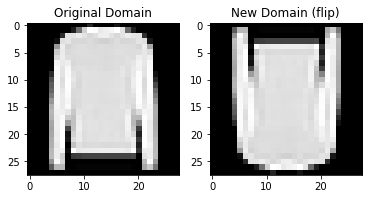

In [11]:
imgs, imgs_flip = next(adpt_ds.as_numpy_iterator())
plt.subplot(1,2,1)
plt.imshow(imgs[0,:,:,0], cmap='gray')
plt.title('Original Domain')
plt.subplot(1,2,2)
plt.title('New Domain (flip)')
plt.imshow(imgs_flip[0,:,:,0], cmap='gray')

## F. Define distilling loss
Let a softmax with an input argument $T$ (called *temperature*) defined as:

$$
softmax(i,T)=\frac{\exp{\left(z_i/T\right)}}{\sum_j{\exp{\left(z_j/T\right)}}}
$$

Using a **higher value for $T$ produces a softer probability distribution** over classes ($T=1$ is original softmax)

- Teacher models: $v_i \begin{array}{cc} \\\overrightarrow{softmax(T)}\end{array} p_i$

- Student models: $z_i \begin{array}{cc} \\\overrightarrow{softmax(T)}\end{array} q_i$

$\text{Gradients}\left[\text{XEnt}(q_i,p_i)\right] \approx \text{Gradients}\left[\text{MSE}(z_i/T,v_i/T)\right]$ under following assumptions:

> 1. If the temperature is high compared with the magnitude of the logits
> 2. original logits have mean $0$, i.e. $\sum{z_i}=\sum{v_i}=0$

More details in Hinton's paper [[Distilling the Knowledge in a Neural Network](https://arxiv.org/abs/1503.02531)]
> - To derive eq (2) in the paper, need to know how to derive the softmax and cross-entorpy.
> - See good ref: [[Derivative of Cross Entropy Loss with Softmax](https://deepnotes.io/softmax-crossentropy#derivative-of-cross-entropy-loss-with-softmax)])


In [12]:
distil_loss_object = tf.keras.losses.MeanSquaredError()
distil_optimizer = tf.keras.optimizers.Adam()
distil_train_loss = tf.keras.metrics.Mean(name='distil_train_loss')

In [13]:
temperature = 5
@tf.function
def distil_train_step(images, images_flip):
    tlogits = teacherModel(images, training=False)
    with tf.GradientTape() as tape:
        # training=True is only needed if there are layers with different
        # behavior during training versus inference (e.g. Dropout).
        slogits = studentModel(images_flip, training=True)
        # Temperature in distilling
        tsloss = distil_loss_object(y_true=tlogits/temperature, y_pred=slogits/temperature)
    gradients = tape.gradient(tsloss, studentModel.trainable_variables)
    distil_optimizer.apply_gradients(zip(gradients, studentModel.trainable_variables))
    distil_train_loss(tsloss)

## G. Domain Adaptation Training
Let student model can classify flipped '6' and '9' **without using labeled flipped '6' and '9' data** to train.

In [14]:
EPOCHS = 5
stime = time.perf_counter()
for epoch in range(EPOCHS):
    # Reset the metrics at the start of the next epoch
    distil_train_loss.reset_states()
    for imgs, imgs_flip in adpt_ds:
        distil_train_step(imgs, imgs_flip)
    
    template = 'Epoch {}, Loss: {}'
    print(template.format(epoch+1, distil_train_loss.result()))
print('total time per epoch = ',(time.perf_counter()-stime)/EPOCHS)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

shape logit =  (32, 2)

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constru

In [15]:
student_test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='student_test_accuracy')
@tf.function
def student_test_step(images, labels):
    # training=False is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    logits = studentModel(images, training=False)
    preds = tf.nn.softmax(logits=logits)
    student_test_accuracy(labels, preds)

---

### Test student model in *ORIGINAL* domain

If accuracy is below 50%, then student model doesn't apply well in original domain

In [16]:
student_test_accuracy.reset_states()
for test_images, test_labels in test_mnist_ds:
    student_test_step(test_images, test_labels)
print('StudentModel\'s Acc in original domain: {}%'.format(student_test_accuracy.result()*100))

test_accuracy.reset_states()
for test_images, test_labels in test_mnist_ds:
    test_step(test_images, test_labels)
print('TeacherModel\'s Acc in original domain: {}%'.format(test_accuracy.result()*100))

shape logit =  (32, 2)
shape logit =  (15, 2)
StudentModel's Acc in original domain: 11.082867622375488%
TeacherModel's Acc in original domain: 99.84748077392578%


---

### Test student model in *NEW* domain (flip image upside down)

If accuracy is approximating 100%, then student model apply well in new domain
> successfully adapt model to new domain with **unsupervised** manner

In [17]:
student_test_accuracy.reset_states()
for test_images, test_labels in test_mnist_ds:
    _, imgs_flip = _create_parallel(test_images)
    student_test_step(imgs_flip, test_labels)
print('StudentModel\'s Acc in new domain: {}%'.format(student_test_accuracy.result()*100))

test_accuracy.reset_states()
for test_images, test_labels in test_mnist_ds:
    _, imgs_flip = _create_parallel(test_images)
    student_test_step(imgs_flip, test_labels)
print('TeacherModel\'s Acc in new domain: {}%'.format(test_accuracy.result()*100))

StudentModel's Acc in new domain: 99.84748077392578%
TeacherModel's Acc in new domain: 0.0%


Check teacher model is intanct

In [18]:
# print(tweight_before_distilling)
tweight_after_distilling = np.copy(teacherModel.weights[-1])
# print(tweight_after_distilling)
assert(np.sum(np.abs(tweight_after_distilling-tweight_before_distilling))==0)